In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Breast_cancer_data.csv')

In [ ]:
features = df.columns[:-1]  # All except the diagnosis column
for col in features:
    df[col] = pd.cut(df[col], bins=5, labels=False)

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the data
split_index = int(0.8 * len(df))
train_df = df[:split_index]
test_df = df[split_index:]

In [ ]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

In [14]:
class MultinomialNB:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.feature_count = X.shape[1]
        self.class_priors = {}
        self.feature_probs = {}

        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / len(X)

            feature_count = np.zeros((self.feature_count, np.max(X) + 1))
            for i in range(self.feature_count):
                values, counts = np.unique(X_c[:, i], return_counts=True)
                for v, count in zip(values, counts):
                    feature_count[i, v] = count

            # Laplace smoothing
            smoothed = feature_count + 1
            probs = smoothed / smoothed.sum(axis=1, keepdims=True)
            self.feature_probs[c] = probs

    def predict(self, X):
        preds = []
        for x in X:
            class_scores = {}
            for c in self.classes:
                log_prob = np.log(self.class_priors[c])
                for i in range(self.feature_count):
                    val = x[i]
                    prob = self.feature_probs[c][i][val]
                    log_prob += np.log(prob)
                class_scores[c] = log_prob
            preds.append(max(class_scores, key=class_scores.get))
        return np.array(preds)

In [15]:
# Train and evaluate
model = MultinomialNB()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [16]:
accuracy = (preds == y_test).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 83.33%


In [17]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

In [18]:
train_acc = (train_preds == y_train).mean()
test_acc = (test_preds == y_test).mean()

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy:  {test_acc * 100:.2f}%")

Train Accuracy: 91.21%
Test Accuracy:  83.33%


In [20]:
def classification_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    report = {}
    for cls in cm.index:
        TP = cm.loc[cls, cls]
        FP = cm[cls].sum() - TP
        FN = cm.loc[cls].sum() - TP
        precision = TP / (TP + FP) if (TP + FP) else 0
        recall = TP / (TP + FN) if (TP + FN) else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
        report[cls] = {"precision": precision, "recall": recall, "f1": f1}
    return pd.DataFrame(report).T

In [21]:
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_preds))


Confusion Matrix (Test):
    0   1
0  31  16
1   3  64


In [22]:
print("\nClassification Report (Test):")
print(classification_report(y_test, test_preds))


Classification Report (Test):
   precision    recall        f1
0   0.911765  0.659574  0.765432
1   0.800000  0.955224  0.870748


Text(0, 0.5, 'Accuracy')

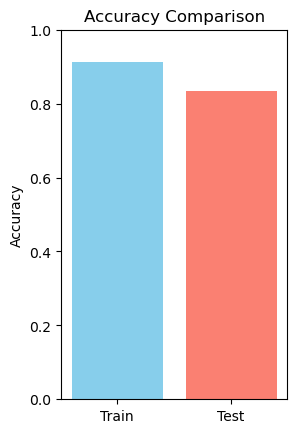

In [25]:
plt.subplot(1, 2, 2)
plt.bar(["Train", "Test"], [train_acc, test_acc], color=["skyblue", "salmon"])
plt.title("Accuracy Comparison")
plt.ylim(0, 1)
plt.ylabel("Accuracy")

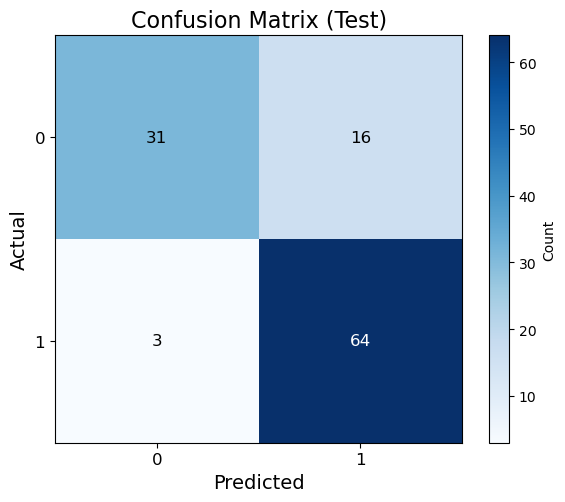

In [26]:
def confusion_matrix(y_true, y_pred):
    classes = np.unique(np.concatenate((y_true, y_pred)))
    matrix = pd.DataFrame(0, index=classes, columns=classes)
    for true, pred in zip(y_true, y_pred):
        matrix.loc[true, pred] += 1
    return matrix

# Compute and plot
cm = confusion_matrix(y_test, test_preds)

# Plot as heatmap
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')

# Axis labels
plt.xticks(ticks=np.arange(len(cm.columns)), labels=cm.columns, fontsize=12)
plt.yticks(ticks=np.arange(len(cm.index)), labels=cm.index, fontsize=12)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix (Test)', fontsize=16)

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm.iat[i, j]),
                 ha='center', va='center',
                 color='white' if cm.iat[i, j] > cm.values.max() / 2 else 'black',
                 fontsize=12)

plt.colorbar(label='Count')
plt.tight_layout()
plt.show()